In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
# Loding the dataset
BTC = pd.read_csv(f"/content/drive/MyDrive/Intel SIP/Crypto_Guides/BTC.csv")
ETH = pd.read_csv(f"/content/drive/MyDrive/Intel SIP/Crypto_Guides/ETH.csv")
LTC = pd.read_csv(f"/content/drive/MyDrive/Intel SIP/Crypto_Guides/LTC.csv")

Text(0, 0.5, 'Prices ($)')

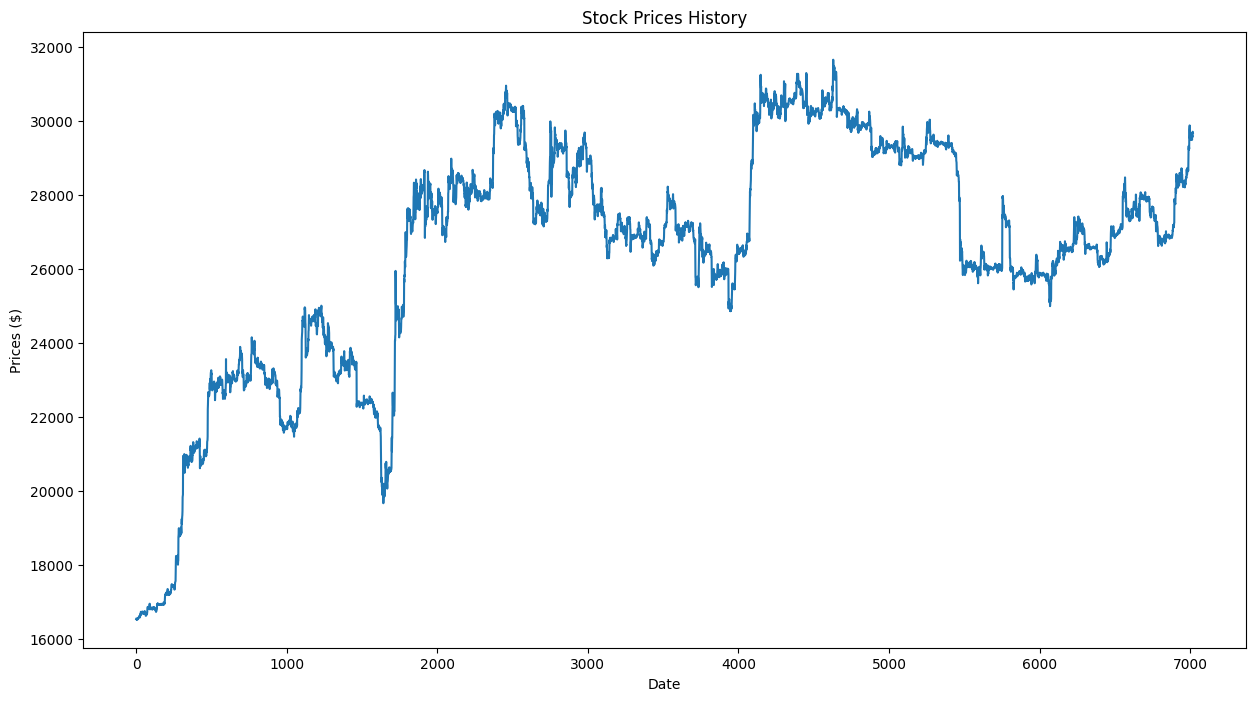

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(BTC['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

## 3-methods for prediction price are:-


* ##   LSTM Time series analysis
* ##  RNN Model
* ##  CNN Model



#LSTM Time-Series analysis

In [27]:
close_prices = BTC['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.5)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_8 (Dense)             (None, 25)                2525      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 8, epochs=2)

Epoch 1/2
432/432 [==============================] - 9s 11ms/step - loss: 0.0029
Epoch 2/2
432/432 [==============================] - 4s 10ms/step - loss: 4.3514e-04


In [8]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

110/110 [==============================] - 1s 4ms/step


106.60428865295607

<ipython-input-9-4005a532d06b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


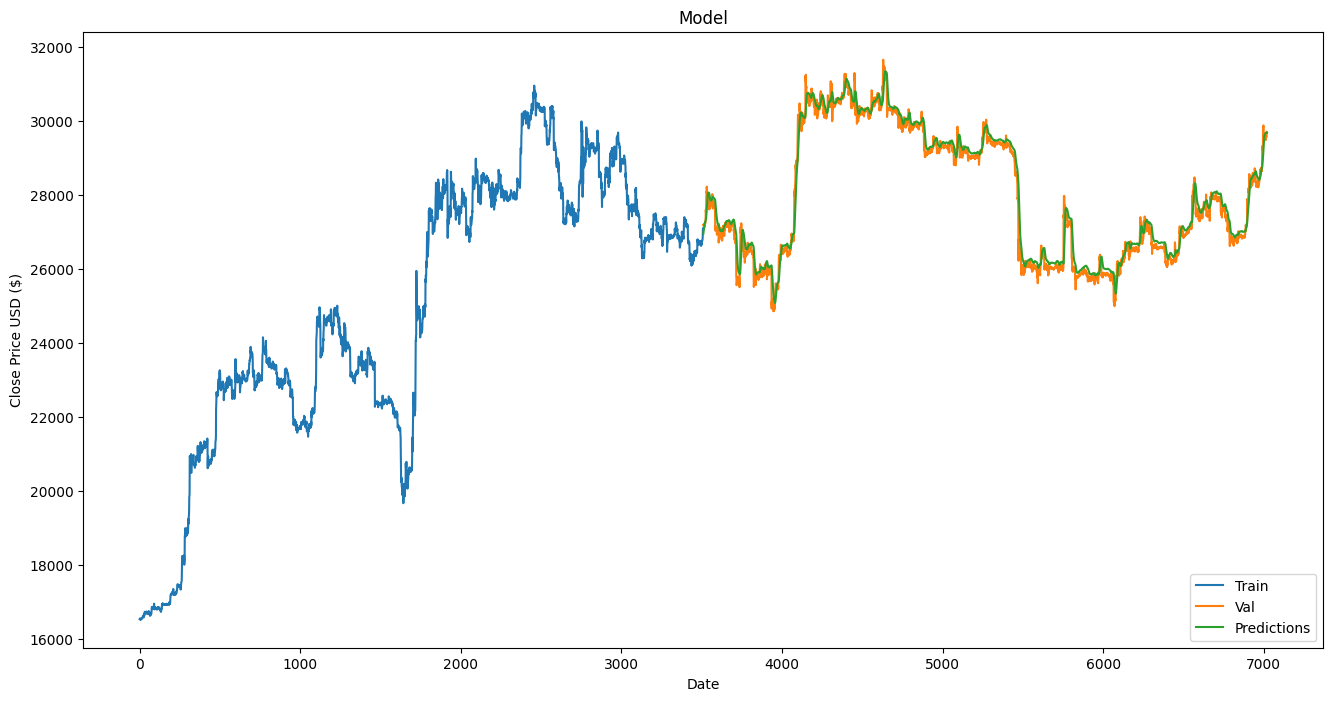

In [9]:
data = BTC.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#RNN

In [10]:
length_data = len(BTC)
split_ratio = 0.9
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
train_data = BTC[:length_train].iloc[:,:2]
validation_data = BTC[length_train:].iloc[:,:2]

In [11]:
dataset_train = train_data.Open.values
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6318, 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(6318, 1)

In [13]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [19]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

regressor = Sequential()
# adding first RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True))
regressor.add(Dropout(0.2))

# adding fourth RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(optimizer = "adam",loss = "mean_squared_error",metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 2, batch_size = 64)

Epoch 1/2
98/98 [==============================] - 29s 255ms/step - loss: 0.2699 - accuracy: 0.0000e+00
Epoch 2/2
98/98 [==============================] - 30s 304ms/step - loss: 0.1070 - accuracy: 1.5954e-04


196/196 [==============================] - 6s 26ms/step


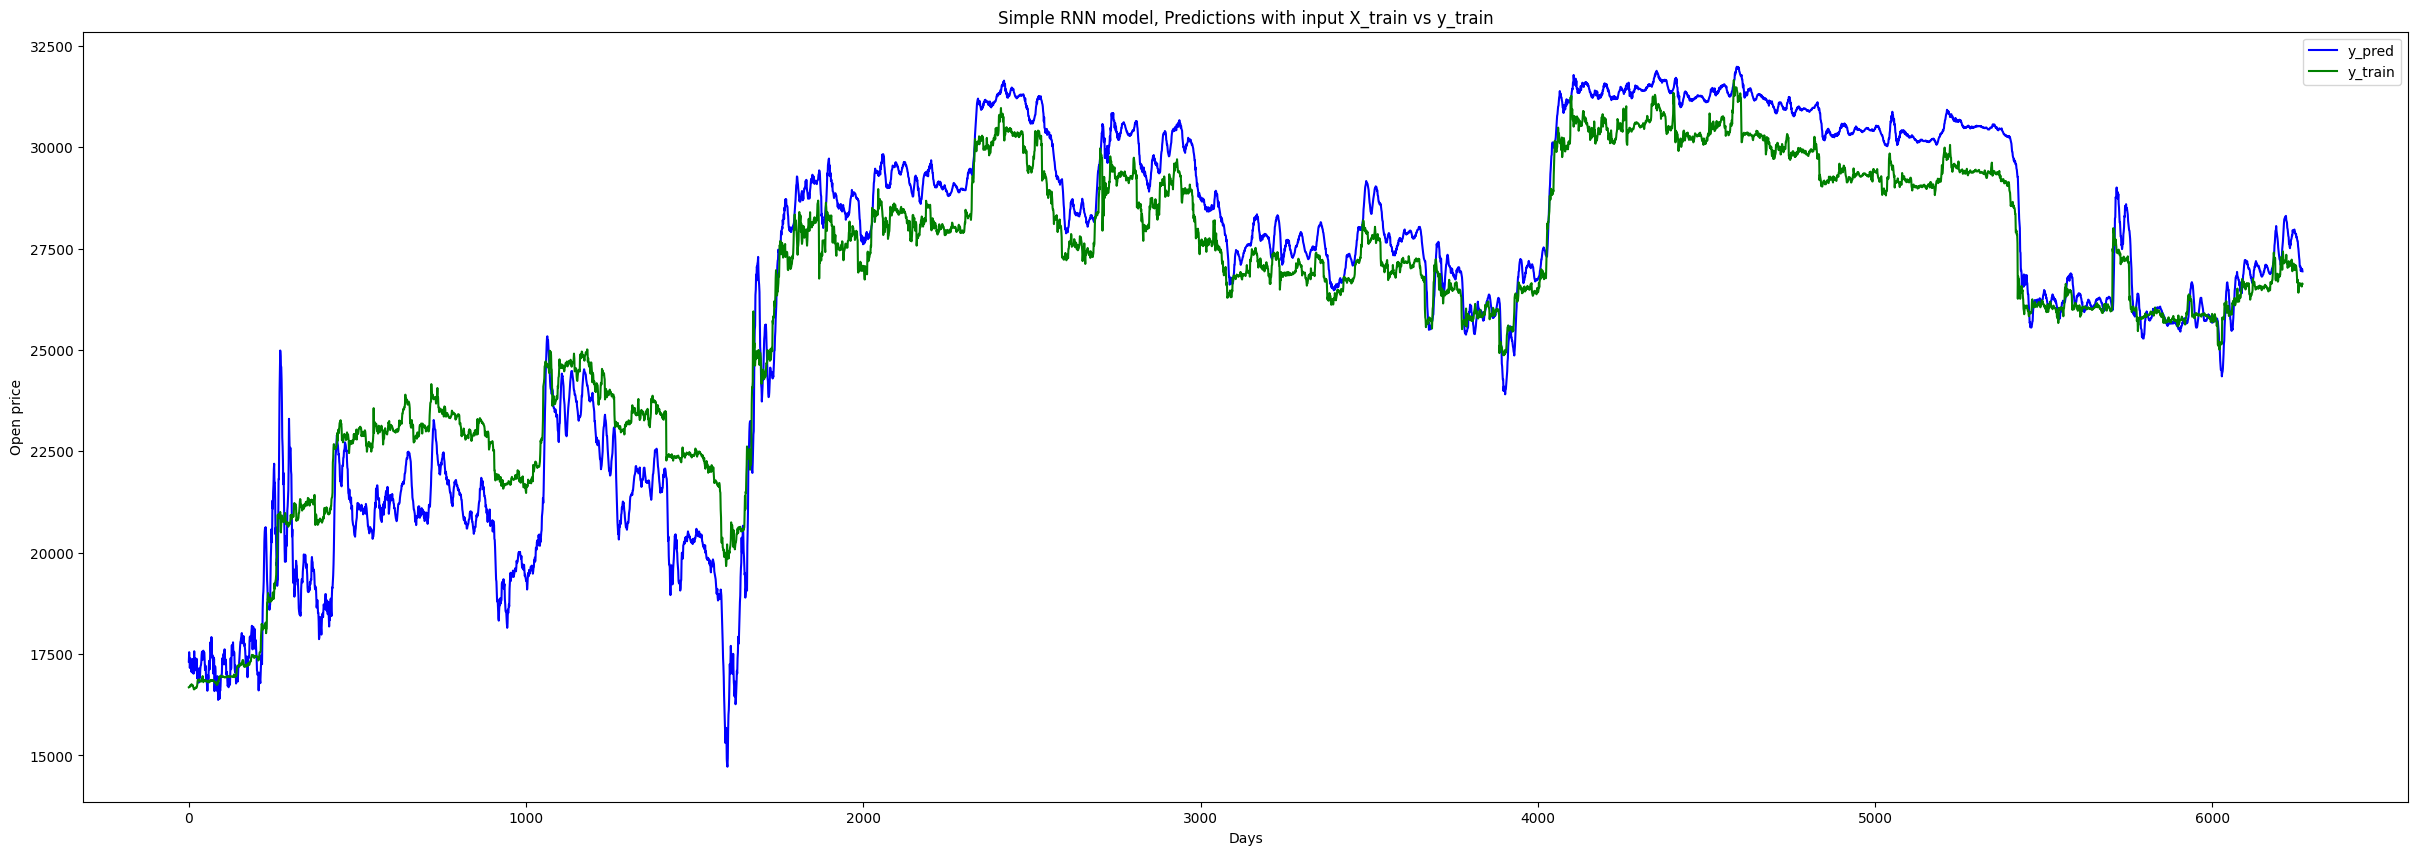

In [20]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
rmse = np.sqrt(np.mean(y_pred - y_train)**2)
rmse
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [21]:
print(rmse)

26570.317920133348


#CNN

In [22]:
length_data = len(BTC)
split_ratio = 0.9
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
train_data = BTC[:length_train].iloc[:,:2]
validation_data = BTC[length_train:].iloc[:,:2]
dataset_train = train_data.Open.values
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6318, 1)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout


CNN = Sequential()
# adding first RNN layer and dropout regulatization
CNN.add(SimpleRNN(units = 50,activation = "tanh",return_sequences = True,input_shape = (X_train.shape[1],1)))
CNN.add(Dropout(0.2))
CNN.add(SimpleRNN(units = 50))
CNN.add(Dropout(0.2))
CNN.add(Dense(units = 32))
# adding the output layer
CNN.add(Dense(units = 1))

# compiling RNN
CNN.compile(optimizer = "adam",loss = "mean_squared_error",metrics = ["accuracy"])

# fitting the RNN
history = CNN.fit(X_train, y_train, epochs = 2, batch_size = 64)

Epoch 1/2
98/98 [==============================] - 13s 100ms/step - loss: 0.0566 - accuracy: 1.5954e-04
Epoch 2/2
98/98 [==============================] - 10s 101ms/step - loss: 0.0098 - accuracy: 1.5954e-04


196/196 [==============================] - 2s 10ms/step


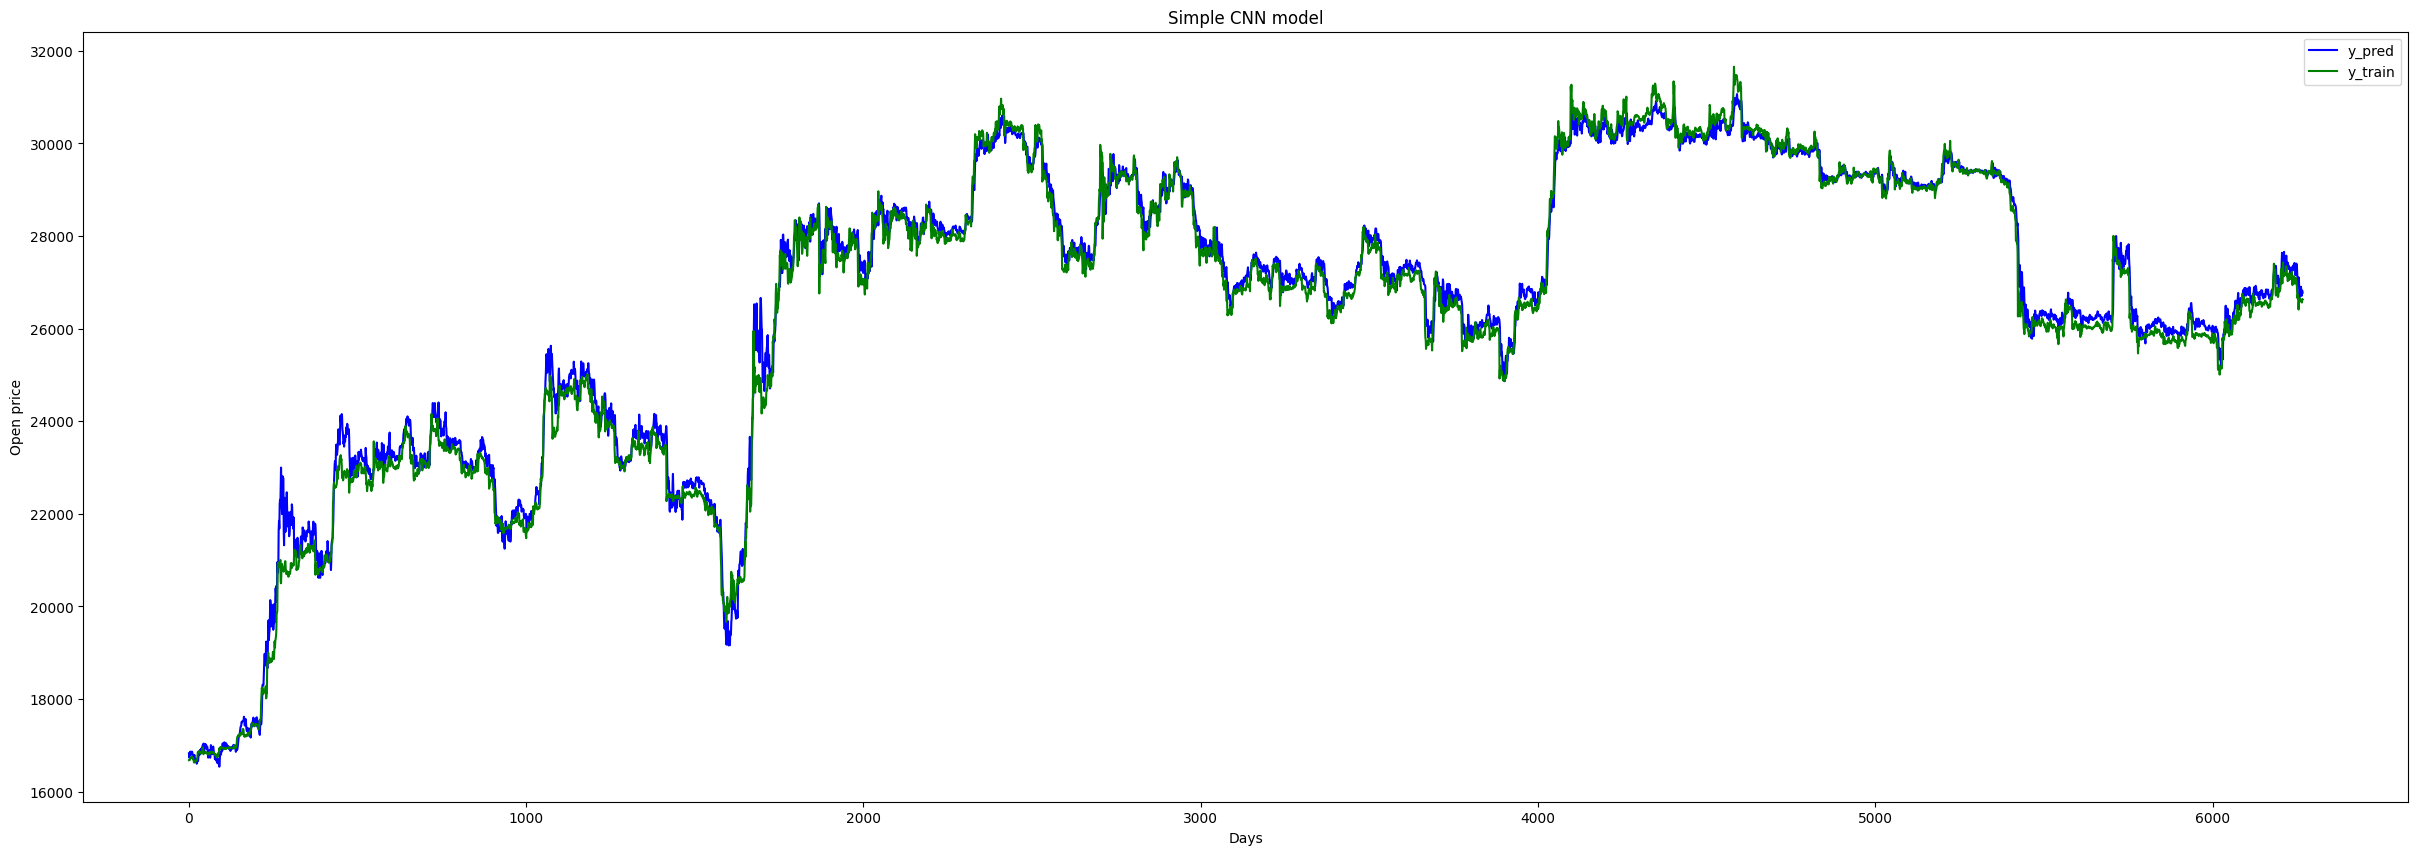

In [25]:
y_pred = CNN.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_train = scaler.inverse_transform(y_train)
plt.figure(figsize = (30,10))
plt.plot(y_pred-100, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple CNN model")
plt.legend()
plt.show()

In [26]:
rmse = np.sqrt(np.mean(y_pred - y_train)**2)
rmse

224.78677667318124

# Conclusion

## RMSE Comparision
---
LSTM Time-Series ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ===⠀⠀⠀⠀⠀106.60428865295607⠀⠀⠀⠀⠀loss: 4.34e-04



---


RNN   ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀===⠀⠀⠀⠀⠀⠀26570.317920133348⠀⠀⠀⠀loss: 0.1070


---


CNN  ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀===⠀⠀⠀⠀⠀⠀224.78677667318124⠀⠀⠀⠀loss: 0.0098



---



##  Lstm Time-Series analysis model will be preferred as it gives the most optimal results with the lowest loss of all the 3 methods and the the most accurate predictions.